In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from datasets import load_dataset
import fastcore.all as fc
import matplotlib.pyplot as plt
import matplotlib as mpl
import torchvision.transforms.functional as TF
from torch.utils.data import default_collate, DataLoader
import torch.optim as optim


In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [2, 2]

In [3]:
dataset_nm = 'mnist'
x,y = 'image', 'label'
ds = load_dataset(dataset_nm)

Found cached dataset mnist (/Users/arun/.cache/huggingface/datasets/mnist/mnist/1.0.0/9d494b7f466d6931c64fb39d58bb1249a4d85c9eb9865d9bc20960b999e2a332)
100%|██████████| 2/2 [00:00<00:00, 75.69it/s]


In [4]:
def transform_ds(b):
    b[x] = [TF.to_tensor(ele) for ele in b[x]]
    return b

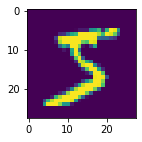

In [5]:
dst = ds.with_transform(transform_ds)
plt.imshow(dst['train'][0]['image'].permute(1,2,0));

In [6]:
bs = 1024
class DataLoaders:
    def __init__(self, train_ds, valid_ds, bs, collate_fn, **kwargs):
        self.train = DataLoader(train_ds, batch_size=bs, shuffle=True, collate_fn=collate_fn, **kwargs)
        self.valid = DataLoader(valid_ds, batch_size=bs, shuffle=False, collate_fn=collate_fn, **kwargs)

def collate_fn(b):
    collate = default_collate(b)
    return (collate[x], collate[y])

In [7]:
dls = DataLoaders(dst['train'], dst['test'], bs=bs, collate_fn=collate_fn)
xb,yb = next(iter(dls.train))
xb.shape, yb.shape

(torch.Size([1024, 1, 28, 28]), torch.Size([1024]))

In [8]:
class Reshape(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    
    def forward(self, x):
        return x.reshape(self.dim)

In [47]:
def conv(ni, nf, ks=3, s=2, act=nn.ReLU, norm=None):
    layers = [nn.Conv2d(ni, nf, kernel_size=ks, stride=s, padding=ks//2)]
    if norm:
        layers.append(norm)
    if act:
        layers.append(act())
    return nn.Sequential(*layers)

def _conv_block(ni, nf, ks=3, s=2, act=nn.ReLU, norm=None):
    return nn.Sequential(
        conv(ni, nf, ks=ks, s=1, norm=None, act=act),
        conv(nf, nf, ks=ks, s=s, norm=norm, act=act),
    )

class ResBlock(nn.Module):
    def __init__(self, ni, nf, s=2, ks=3, act=nn.ReLU, norm=None):
        super().__init__()
        self.convs = _conv_block(ni, nf, s=s, ks=ks, act=act, norm=norm)
        self.idconv = fc.noop if ni==nf else conv(ni, nf, ks=1, s=1, act=None)
        self.pool = fc.noop if s==1 else nn.AvgPool2d(2, ceil_mode=True)
        self.act = act()
    
    def forward(self, x):
        return self.act(self.convs(x) + self.idconv(self.pool(x)))

In [48]:
def cnn_classifier():
    return nn.Sequential(
        ResBlock(1, 8, norm=nn.LayerNorm([8, 14, 14])),
        ResBlock(8, 16, norm=nn.LayerNorm([16, 7, 7])),
        ResBlock(16, 32, norm=nn.LayerNorm([32, 4, 4])),
        ResBlock(32, 64, norm=nn.LayerNorm([64, 2, 2])),
        ResBlock(64, 64,  norm=nn.LayerNorm([64, 1, 1])),
        conv(64, 10, act=False),
        nn.Flatten(),
    )

In [49]:
def kaiming_init(m):
    if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Conv3d)):
        nn.init.kaiming_normal_(m.weight)        

In [50]:
model = cnn_classifier()
model.apply(kaiming_init)
lr = 0.1
max_lr = 0.3
epochs = 5
opt = optim.AdamW(model.parameters(), lr=lr)
sched = optim.lr_scheduler.OneCycleLR(opt, max_lr, total_steps=len(dls.train), epochs=epochs)
for epoch in range(epochs):
    for train in (True, False):
        accuracy = 0
        total_loss = 0
        dl = dls.train if train else dls.valid
        for xb,yb in dl:
            preds = model(xb)
            loss = F.cross_entropy(preds, yb)
            if train:
                loss.backward()
                opt.step()
                opt.zero_grad()
            with torch.no_grad():
                accuracy += (preds.argmax(1).detach().cpu() == yb).float().mean()
                total_loss  += loss.item()
        if train:
            sched.step()
        accuracy /= len(dl)
        total_loss /= len(dl)
        print(f"{'train' if train else 'eval'}, epoch:{epoch+1}, loss: {total_loss:.4f}, accuracy: {accuracy:.4f}")

train, epoch:1, loss: 1.8902, accuracy: 0.3183
eval, epoch:1, loss: 1.0976, accuracy: 0.6274
train, epoch:2, loss: 0.5929, accuracy: 0.8003
eval, epoch:2, loss: 0.2895, accuracy: 0.9102
train, epoch:3, loss: 0.2396, accuracy: 0.9264
eval, epoch:3, loss: 0.1343, accuracy: 0.9597
train, epoch:4, loss: 0.1139, accuracy: 0.9651
eval, epoch:4, loss: 0.0801, accuracy: 0.9763
train, epoch:5, loss: 0.1368, accuracy: 0.9582
eval, epoch:5, loss: 0.0882, accuracy: 0.9722


In [51]:
for epoch in range(epochs):
        train = False
        accuracy = 0
        total_loss = 0
        dl = dls.valid
        for xb,yb in dl:
            preds = model(xb)
            loss = F.cross_entropy(preds, yb)
            with torch.no_grad():
                accuracy += (preds.argmax(1).detach().cpu() == yb).float().mean()
                total_loss  += loss.item()
        accuracy /= len(dl)
        total_loss /= len(dl)
        print(f"{'train' if train else 'eval'}, epoch:{epoch+1}, loss: {total_loss:.4f}, accuracy: {accuracy:.4f}")

eval, epoch:1, loss: 0.0882, accuracy: 0.9722
eval, epoch:2, loss: 0.0882, accuracy: 0.9722
eval, epoch:3, loss: 0.0882, accuracy: 0.9722
eval, epoch:4, loss: 0.0882, accuracy: 0.9722
eval, epoch:5, loss: 0.0882, accuracy: 0.9722


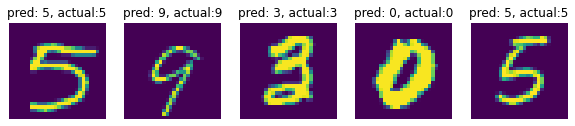

In [52]:
xbv,ybv = next(iter(dls.train))
logits = model(xbv)
probs = F.softmax(logits, dim=1)
idx = 5
_,axs = plt.subplots(1, idx, figsize=(10, 10))
for actual, pred, im, ax in zip(ybv[:idx], probs[:idx],xbv.permute(0,2,3,1)[:idx], axs.flat):
    ax.imshow(im)
    ax.set_axis_off()
    ax.set_title(f'pred: {pred.argmax(0).item()}, actual:{actual.item()}')
    

In [53]:
torch.save(model.state_dict(), 'classifier.pth')

In [54]:
loaded_model = cnn_classifier()
loaded_model.load_state_dict(torch.load('classifier.pth'));
loaded_model.eval();

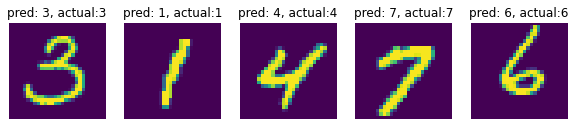

In [55]:
with torch.no_grad():
    xbv,ybv = next(iter(dls.train))
    logits = loaded_model(xbv)
    probs = F.softmax(logits, dim=1)
    idx = 5
    _,axs = plt.subplots(1, idx, figsize=(10, 10))
    for actual, pred, im, ax in zip(ybv[:idx], probs[:idx],xbv.permute(0,2,3,1)[:idx], axs.flat):
        ax.imshow(im)
        ax.set_axis_off()
        ax.set_title(f'pred: {pred.argmax(0).item()}, actual:{actual.item()}')
        

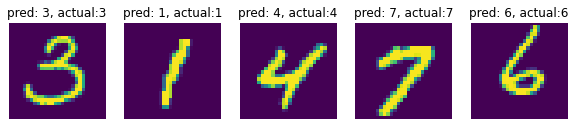

In [56]:
logits = model(xbv)
probs = F.softmax(logits, dim=1)
idx = 5
_,axs = plt.subplots(1, idx, figsize=(10, 10))
for actual, pred, im, ax in zip(ybv[:idx], probs[:idx],xbv.permute(0,2,3,1)[:idx], axs.flat):
    ax.imshow(im)
    ax.set_axis_off()
    ax.set_title(f'pred: {pred.argmax(0).item()}, actual:{actual.item()}')
    

In [57]:
def predict(img):
    with torch.no_grad():
        img = img[None,]
        pred = loaded_model(img)[0]
        pred_probs = F.softmax(pred, dim=0)
        pred = [{"digit": i, "prob": f'{prob*100:.2f}%', 'logits': pred[i]} for i, prob in enumerate(pred_probs)]
        pred = sorted(pred, key=lambda ele: ele['digit'], reverse=False)
    return pred

In [58]:
img = xb[1].reshape(1, 28, 28)
print(yb[1])
predict(img)

tensor(3)


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


[{'digit': 0, 'prob': '0.00%', 'logits': tensor(-5.5980)},
 {'digit': 1, 'prob': '0.00%', 'logits': tensor(-0.4972)},
 {'digit': 2, 'prob': '0.02%', 'logits': tensor(1.2516)},
 {'digit': 3, 'prob': '99.95%', 'logits': tensor(9.9263)},
 {'digit': 4, 'prob': '0.00%', 'logits': tensor(-5.5094)},
 {'digit': 5, 'prob': '0.01%', 'logits': tensor(0.2367)},
 {'digit': 6, 'prob': '0.00%', 'logits': tensor(-9.4633)},
 {'digit': 7, 'prob': '0.00%', 'logits': tensor(-2.4315)},
 {'digit': 8, 'prob': '0.02%', 'logits': tensor(1.4733)},
 {'digit': 9, 'prob': '0.00%', 'logits': tensor(-0.0205)}]

#### commit to .py file for deployment

In [79]:
!jupyter nbconvert --to script --TagRemovePreprocessor.remove_cell_tags="exclude" --TemplateExporter.exclude_input_prompt=True mnist_classifier.ipynb


[NbConvertApp] Converting notebook mnist_classifier.ipynb to script
[NbConvertApp] Writing 2920 bytes to mnist_classifier.py


tensor(0.1046) tensor(1.) tensor(0.) tensor(0.3062)
tensor(0.1435) tensor(1.) tensor(0.) tensor(0.3220)


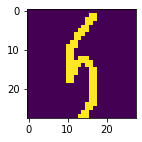

In [78]:
from PIL import Image
import numpy as np
import glob
import os
png_files = glob.glob(os.path.join('./uploads', '*png'))
img = png_files[1]
image = Image.open(img)
image = TF.to_tensor(image).permute(1, 2, 0)
print(image.mean(), image.max(), image.min(), image.std())
print(xb[0].mean(), xb[0].max(), xb[0].min(), xb[0].std())
plt.imshow(image);

